In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def prepare_data():
    paths = ['cosine_1.npy', 'cosine_2.npy']
    data  = []

    for path in paths:
        data.append(np.load('/content/gdrive/My Drive/data/stereo_matching/'+path))
        
    data = np.array(data)
    data = np.vstack(data)
    
    data = data.transpose((0, 4, 2, 3, 1))
    data = data.reshape(data.shape[0], 15, 15, 2)
    
    # normalization
    mean = np.mean(data)
    std  = np.std(data)
    data = (data - mean)/(std+1e-7)
    
    return data

In [ ]:
# Cosine Similarity function
def cosineSimilarity(x):
    x1 = x[:,:,0].reshape(1,-1)
    x2 = x[:,:,1].reshape(1,-1)
    return cosine_similarity(x1,x2)[0][0]

In [ ]:
# get data
data = prepare_data()

# compute labels
Y = np.array([cosineSimilarity(data[i]) for i in range(data.shape[0])])
print(Y.shape)

np.save('/content/gdrive/My Drive/data/stereo_matching/labels_consine_v2.npy', Y)

(2000000,)


In [ ]:
# get data
data = prepare_data()
print(data.shape)

# get labels
Y = np.load('/content/gdrive/My Drive/data/stereo_matching/labels_consine_v2.npy')
print(Y.shape)

(2000000, 15, 15, 2)
(2000000,)


In [ ]:
# shuffle
data_size = data.shape[0]

rng = np.random.RandomState(113)
indices = np.arange(data_size)

rng.shuffle(indices)
data = data[indices]
Y = Y[indices]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
import tensorflow as tf

def base_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (1,1),activation='relu', kernel_initializer='he_uniform')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (1,1), activation='tanh')(x)
    x = tf.squeeze(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
model = base_model((None,None,2))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 32)    96        
_________________________________________________________________
batch_normalization_8 (Batch (None, None, None, 32)    128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, None, None, 32)    128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, None, None, 32)    128 

In [ ]:
#training
batch_size = 512
epochs = 30

opt_adam  = keras.optimizers.Adam()
model.compile(loss='mse', optimizer=opt_adam)
history = model.fit(data, Y, batch_size = batch_size, epochs=epochs)

Epoch 1/30
3907/3907 [==============================] - 73s 11ms/step - loss: 0.0275
Epoch 2/30
3907/3907 [==============================] - 42s 11ms/step - loss: 0.0044
Epoch 3/30
3907/3907 [==============================] - 42s 11ms/step - loss: 0.0022
Epoch 4/30
3907/3907 [==============================] - 41s 11ms/step - loss: 0.0015
Epoch 5/30
3907/3907 [==============================] - 41s 11ms/step - loss: 0.0012
Epoch 6/30
3907/3907 [==============================] - 41s 11ms/step - loss: 0.0010
Epoch 7/30
3907/3907 [==============================] - 41s 11ms/step - loss: 9.2931e-04
Epoch 8/30
3907/3907 [==============================] - 41s 11ms/step - loss: 8.1662e-04
Epoch 9/30
3907/3907 [==============================] - 41s 11ms/step - loss: 7.7253e-04
Epoch 10/30
3907/3907 [==============================] - 41s 11ms/step - loss: 7.1406e-04
Epoch 11/30
3907/3907 [==============================] - 41s 11ms/step - loss: 6.6400e-04
Epoch 12/30
3907/3907 [====================

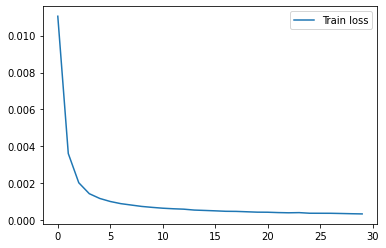

In [ ]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
#plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.legend()

In [ ]:
#Save model to cosin.h5 file
model.save('/content/gdrive/My Drive/data/stereo_matching/model_cosine_fit_v3.h5')